# Store Item Demand Forecasting with Baseline LSTM Regressor

## Import required libraries

In [1]:
import pandas as pd
pd.options.display.max_columns = 12
pd.options.display.max_rows = 24

import warnings
warnings.simplefilter('ignore')

%matplotlib inline
import matplotlib.pyplot as plt

import seaborn as sns
sns.set()

import numpy as np

%config InlineBackend.figure_format = 'svg'

from pylab import rcParams
rcParams['figure.figsize'] = 5, 4

from itertools import product, starmap

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

from keras.models import Sequential, Model
from keras.layers import *

import time
from keras.callbacks import EarlyStopping,ModelCheckpoint
from keras.losses import MeanSquaredError

from keras import models 

from scipy.stats import describe
from sklearn.metrics import mean_squared_error, r2_score

## Read datasets

In [2]:
# google colab
from google.colab import drive
drive.mount('/content/drive')

df_train = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/ml project/train.csv', parse_dates = ['date'])
df_test = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/ml project/test.csv', parse_dates = ['date'])

Mounted at /content/drive


In [3]:
# # jupyter
# df_train = pd.read_csv('train.csv', parse_dates = ['date'])
# df_test = pd.read_csv('test.csv', parse_dates = ['date'])

In [4]:
df_train.head()

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10


In [5]:
df_test.head()

,id,date,store,item
0,0,2018-01-01,1,1
1,1,2018-01-02,1,1
2,2,2018-01-03,1,1
3,3,2018-01-04,1,1
4,4,2018-01-05,1,1


## Preprocess data

### Convert strings to dates

In [6]:
df_train['date'] = pd.to_datetime(df_train['date'])
df_train.index = pd.DatetimeIndex(df_train['date'])
df_train.drop('date', axis=1, inplace=True)

In [7]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 913000 entries, 2013-01-01 to 2017-12-31
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype
---  ------  --------------   -----
 0   store   913000 non-null  int64
 1   item    913000 non-null  int64
 2   sales   913000 non-null  int64
dtypes: int64(3)
memory usage: 27.9 MB


In [8]:
df_test['date'] = pd.to_datetime(df_test['date'])
df_test.index = pd.DatetimeIndex(df_test['date'])
df_test.drop('date', axis=1, inplace=True)

In [9]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 45000 entries, 2018-01-01 to 2018-03-31
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   id      45000 non-null  int64
 1   store   45000 non-null  int64
 2   item    45000 non-null  int64
dtypes: int64(3)
memory usage: 1.4 MB


### Sales for each storeitem

In [10]:
def storeitems():

    return product(range(1,51), range(1,11))


def storeitems_column_names():

    return list(starmap(lambda i,s: f'item_{i}_store_{s}_sales', storeitems()))


def sales_by_storeitem(df):
    ret = pd.DataFrame(index=df.index.unique())
    for i, s in storeitems():
        ret[f'item_{i}_store_{s}_sales'] = df[(df['item'] == i) & (df['store'] == s)]['sales'].values
        
    return ret

In [11]:
df_train = sales_by_storeitem(df_train)

In [12]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1826 entries, 2013-01-01 to 2017-12-31
Columns: 500 entries, item_1_store_1_sales to item_50_store_10_sales
dtypes: int64(500)
memory usage: 7.0 MB


### Mock sales to use same transformations as train data

In [13]:
df_test['sales'] = np.zeros(df_test.shape[0])
df_test = sales_by_storeitem(df_test)

In [14]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 90 entries, 2018-01-01 to 2018-03-31
Columns: 500 entries, item_1_store_1_sales to item_50_store_10_sales
dtypes: float64(500)
memory usage: 352.3 KB


### Combine train and test data

In [15]:
# ensure columns have same name and order
col_names = list(zip(df_test.columns, df_train.columns))
for cn in col_names:
    assert cn[0] == cn[1]

In [16]:
df_test['is_test'] = np.repeat(True, df_test.shape[0])
df_train['is_test'] = np.repeat(False, df_train.shape[0])
df_total = pd.concat([df_train, df_test])
df_total.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1916 entries, 2013-01-01 to 2018-03-31
Columns: 501 entries, item_1_store_1_sales to is_test
dtypes: bool(1), float64(500)
memory usage: 7.3 MB


### One-Hot encoding

In [17]:
weekday_df = pd.get_dummies(df_total.index.weekday, prefix='weekday')
weekday_df.index = df_total.index

weekday_df.head()

,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
date,,,,,,,
2013-01-01,0,1,0,0,0,0,0
2013-01-02,0,0,1,0,0,0,0
2013-01-03,0,0,0,1,0,0,0
2013-01-04,0,0,0,0,1,0,0
2013-01-05,0,0,0,0,0,1,0


In [18]:
month_df = pd.get_dummies(df_total.index.month, prefix='month')
month_df.index =  df_total.index

month_df.head()

,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
date,,,,,,,,,,,,
2013-01-01,1,0,0,0,0,0,0,0,0,0,0,0
2013-01-02,1,0,0,0,0,0,0,0,0,0,0,0
2013-01-03,1,0,0,0,0,0,0,0,0,0,0,0
2013-01-04,1,0,0,0,0,0,0,0,0,0,0,0
2013-01-05,1,0,0,0,0,0,0,0,0,0,0,0


In [19]:
weekyear_df = pd.get_dummies(df_total.index.weekofyear, prefix='weekyear')
weekyear_df.index =  df_total.index

weekyear_df.head()

,weekyear_1,weekyear_2,weekyear_3,weekyear_4,weekyear_5,weekyear_6,...,weekyear_48,weekyear_49,weekyear_50,weekyear_51,weekyear_52,weekyear_53
date,,,,,,,,,,,,,
2013-01-01,1,0,0,0,0,0,...,0,0,0,0,0,0
2013-01-02,1,0,0,0,0,0,...,0,0,0,0,0,0
2013-01-03,1,0,0,0,0,0,...,0,0,0,0,0,0
2013-01-04,1,0,0,0,0,0,...,0,0,0,0,0,0
2013-01-05,1,0,0,0,0,0,...,0,0,0,0,0,0


In [20]:
quarter_df = pd.get_dummies(df_total.index.quarter, prefix='quarter')
quarter_df.index =  df_total.index

quarter_df.head()

,quarter_1,quarter_2,quarter_3,quarter_4
date,,,,
2013-01-01,1,0,0,0
2013-01-02,1,0,0,0
2013-01-03,1,0,0,0
2013-01-04,1,0,0,0
2013-01-05,1,0,0,0


In [21]:
df_total = pd.concat([weekday_df, month_df, weekyear_df, quarter_df, df_total], axis=1)

df_total.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1916 entries, 2013-01-01 to 2018-03-31
Columns: 577 entries, weekday_0 to is_test
dtypes: bool(1), float64(500), uint8(76)
memory usage: 7.5 MB


In [22]:
assert df_total.isna().any().any() == False

### Shift sales 


In [23]:
def shift_series(series, days):

    return series.transform(lambda x: x.shift(days))


def shift_series_in_df(df, series_names=[], days_delta=90):
    ret = pd.DataFrame(index=df.index.copy())
    str_sgn = 'future' if np.sign(days_delta) < 0 else 'past'
    for sn in series_names:
        ret[f'{sn}_{str_sgn}_{np.abs(days_delta)}'] = shift_series(df[sn], days_delta)

    return ret

    
def stack_shifted_sales(df, days_delta=90):
    names = storeitems_column_names()
    dfs = [df.copy()]
    abs_range = range(1, days_delta+1) if days_delta > 0 else range(days_delta, 0)
    for day_offset in abs_range:
        delta = -day_offset
        shifted = shift_series_in_df(df, series_names=names, days_delta=delta)
        dfs.append(shifted)
        
    return pd.concat(dfs, axis=1, copy=False)

In [24]:
df_total = stack_shifted_sales(df_total, days_delta=-1)

In [25]:
# remove 1st row
df_total = df_total.dropna()  

df_total.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1915 entries, 2013-01-02 to 2018-03-31
Columns: 1077 entries, weekday_0 to item_50_store_10_sales_past_1
dtypes: bool(1), float64(1000), uint8(76)
memory usage: 14.8 MB


In [26]:
# ensure stacked and standard sales columns in same order
sales_cols = [col for col in df_total.columns if '_sales' in col and '_sales_' not in col]
stacked_sales_cols = [col for col in df_total.columns if '_sales_' in col]
other_cols = [col for col in df_total.columns if col not in set(sales_cols) and col not in set(stacked_sales_cols)]

sales_cols = sorted(sales_cols)
stacked_sales_cols = sorted(stacked_sales_cols)

new_cols = other_cols + stacked_sales_cols + sales_cols

In [27]:
df_total = df_total.reindex(columns=new_cols)

In [28]:
df_total.head()

,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,...,item_9_store_4_sales,item_9_store_5_sales,item_9_store_6_sales,item_9_store_7_sales,item_9_store_8_sales,item_9_store_9_sales
date,,,,,,,,,,,,,
2013-01-02,0,0,1,0,0,0,...,21.0,20.0,17.0,20.0,28.0,36.0
2013-01-03,0,0,0,1,0,0,...,25.0,15.0,28.0,18.0,31.0,25.0
2013-01-04,0,0,0,0,1,0,...,37.0,20.0,33.0,24.0,46.0,31.0
2013-01-05,0,0,0,0,0,1,...,37.0,23.0,27.0,14.0,35.0,30.0
2013-01-06,0,0,0,0,0,0,...,37.0,29.0,20.0,24.0,34.0,35.0


In [29]:
df_total.describe()

,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,...,item_9_store_4_sales,item_9_store_5_sales,item_9_store_6_sales,item_9_store_7_sales,item_9_store_8_sales,item_9_store_9_sales
count,1915.000000,1915.000000,1915.000000,1915.000000,1915.000000,1915.000000,...,1915.000000,1915.000000,1915.000000,1915.000000,1915.000000,1915.000000
mean,0.142559,0.142559,0.143081,0.143081,0.143081,0.143081,...,51.522193,37.021410,37.613055,34.219321,60.241253,51.577023
std,0.349714,0.349714,0.350247,0.350247,0.350247,0.350247,...,18.707446,13.864136,13.968996,12.788732,21.714863,18.706826
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,41.000000,29.000000,30.000000,27.000000,48.000000,41.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,52.000000,38.000000,38.000000,35.000000,61.000000,52.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,64.000000,46.000000,46.000000,42.000000,74.000000,63.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,111.000000,84.000000,81.000000,78.000000,134.000000,110.000000


In [30]:
assert df_total.isna().any().any() == False

### Scaling

In [31]:
cols_to_scale = [col for col in df_total.columns if 'weekday' not in col and 'month' not in col and 'weekyear' not in col and 'quarter' not in col]

In [32]:
scaler = MinMaxScaler(feature_range=(0,1))
scaled_cols = scaler.fit_transform(df_total[cols_to_scale])
df_total[cols_to_scale] = scaled_cols

df_total.head()

,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,...,item_9_store_4_sales,item_9_store_5_sales,item_9_store_6_sales,item_9_store_7_sales,item_9_store_8_sales,item_9_store_9_sales
date,,,,,,,,,,,,,
2013-01-02,0,0,1,0,0,0,...,0.189189,0.238095,0.209877,0.256410,0.208955,0.327273
2013-01-03,0,0,0,1,0,0,...,0.225225,0.178571,0.345679,0.230769,0.231343,0.227273
2013-01-04,0,0,0,0,1,0,...,0.333333,0.238095,0.407407,0.307692,0.343284,0.281818
2013-01-05,0,0,0,0,0,1,...,0.333333,0.273810,0.333333,0.179487,0.261194,0.272727
2013-01-06,0,0,0,0,0,0,...,0.333333,0.345238,0.246914,0.307692,0.253731,0.318182


In [33]:
df_total.describe()

,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,...,item_9_store_4_sales,item_9_store_5_sales,item_9_store_6_sales,item_9_store_7_sales,item_9_store_8_sales,item_9_store_9_sales
count,1915.000000,1915.000000,1915.000000,1915.000000,1915.000000,1915.000000,...,1915.000000,1915.000000,1915.000000,1915.000000,1915.000000,1915.000000
mean,0.142559,0.142559,0.143081,0.143081,0.143081,0.143081,...,0.464164,0.440731,0.464359,0.438709,0.449562,0.468882
std,0.349714,0.349714,0.350247,0.350247,0.350247,0.350247,...,0.168536,0.165049,0.172457,0.163958,0.162051,0.170062
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.369369,0.345238,0.370370,0.346154,0.358209,0.372727
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.468468,0.452381,0.469136,0.448718,0.455224,0.472727
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.576577,0.547619,0.567901,0.538462,0.552239,0.572727
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### Split back to train and test data

In [34]:
df_train = df_total[df_total['is_test'] == False].drop('is_test', axis=1)
df_test = df_total[df_total['is_test'] == True].drop('is_test', axis=1)

In [35]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1825 entries, 2013-01-02 to 2017-12-31
Columns: 1076 entries, weekday_0 to item_9_store_9_sales
dtypes: float64(1000), uint8(76)
memory usage: 14.1 MB


In [36]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 90 entries, 2018-01-01 to 2018-03-31
Columns: 1076 entries, weekday_0 to item_9_store_9_sales
dtypes: float64(1000), uint8(76)
memory usage: 710.5 KB


### Prepare training data

In [37]:
X_cols_stacked = [col for col in df_train.columns if '_past_' in col]
X_cols_caldata = [col for col in df_train.columns if 'weekday_' in col or 'month_' in col or 'weekyear_' in col or 'quarter_' in col]
X_cols = X_cols_stacked + X_cols_caldata

X = df_train[X_cols]

In [38]:
X_colset = set(X_cols)
y_cols = [col for col in df_train.columns if col not in X_colset]

y = df_train[y_cols]

In [39]:
X.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1825 entries, 2013-01-02 to 2017-12-31
Columns: 576 entries, item_10_store_10_sales_past_1 to quarter_4
dtypes: float64(500), uint8(76)
memory usage: 7.1 MB


In [40]:
y.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1825 entries, 2013-01-02 to 2017-12-31
Columns: 500 entries, item_10_store_10_sales to item_9_store_9_sales
dtypes: float64(500)
memory usage: 7.0 MB


In [41]:
# split training data into train and val (80-20)
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, shuffle=False)

In [42]:
X_train.shape, X_valid.shape

((1460, 576), (365, 576))

In [43]:
y_train.shape, y_valid.shape

((1460, 500), (365, 500))

In [44]:
# reshape inputs to be 3d
X_train_vals = X_train.values.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_valid_vals = X_valid.values.reshape((X_valid.shape[0], 1, X_valid.shape[1]))

In [45]:
X_train_vals.shape, X_valid_vals.shape

((1460, 1, 576), (365, 1, 576))

## LSTM model

In [46]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=10)

In [47]:
cp = ModelCheckpoint("lstm-base_regressor.hdf5", monitor='loss', verbose=1,save_best_only=True)

In [48]:
def build_model():

  model = Sequential()
  model.add(LSTM(500, activation='relu', input_shape=(X_train_vals.shape[1], X_train_vals.shape[2])))
  model.add(Dense(1))

  model.compile(optimizer='adam', loss='mse')

  model.summary()
    
  return model

In [49]:
model = build_model()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 500)               2154000   
                                                                 
 dense (Dense)               (None, 1)                 501       
                                                                 
Total params: 2,154,501
Trainable params: 2,154,501
Non-trainable params: 0
_________________________________________________________________


In [50]:
t0 = time.time()

history = model.fit(
    X_train_vals, 
    y_train.values, 
    epochs=200, 
    batch_size=50,
    validation_data=(X_valid_vals, y_valid.values),
    verbose=2,
    shuffle=False,
    callbacks=[early_stop, cp]
)

t1 = time.time()
train_time = t1 - t0

Epoch 1/200

Epoch 1: loss improved from inf to 0.03461, saving model to lstm-base_regressor.hdf5
30/30 - 4s - loss: 0.0346 - val_loss: 0.0154 - 4s/epoch - 131ms/step
Epoch 2/200

Epoch 2: loss improved from 0.03461 to 0.01084, saving model to lstm-base_regressor.hdf5
30/30 - 0s - loss: 0.0108 - val_loss: 0.0123 - 247ms/epoch - 8ms/step
Epoch 3/200

Epoch 3: loss improved from 0.01084 to 0.00927, saving model to lstm-base_regressor.hdf5
30/30 - 0s - loss: 0.0093 - val_loss: 0.0106 - 253ms/epoch - 8ms/step
Epoch 4/200

Epoch 4: loss improved from 0.00927 to 0.00875, saving model to lstm-base_regressor.hdf5
30/30 - 0s - loss: 0.0088 - val_loss: 0.0109 - 228ms/epoch - 8ms/step
Epoch 5/200

Epoch 5: loss did not improve from 0.00875
30/30 - 0s - loss: 0.0091 - val_loss: 0.0090 - 186ms/epoch - 6ms/step
Epoch 6/200

Epoch 6: loss improved from 0.00875 to 0.00787, saving model to lstm-base_regressor.hdf5
30/30 - 0s - loss: 0.0079 - val_loss: 0.0094 - 240ms/epoch - 8ms/step
Epoch 7/200

Epoch 

## Model evaluation

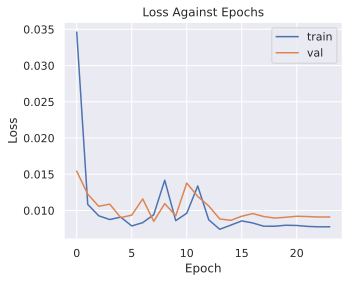

<Figure size 360x288 with 0 Axes>

In [51]:
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.title('Loss Against Epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

plt.savefig('LSTM Base Loss Against Epoch.png')

In [52]:
def model_eval(model, X_test, y_test, log_all=False):
    sales_x_cols = [col for col in X_test.columns if 'sales' in col]
    sales_x_idxs = [X_test.columns.get_loc(col) for col in sales_x_cols]
    sales_y_cols = [col for col in y_test.columns if 'sales' in col]
    sales_y_idxs = [y_test.columns.get_loc(col) for col in sales_y_cols]
    n_samples = y_test.shape[0]
    y_pred = np.zeros(y_test.shape)

    x_next = X_test.iloc[0].values
    for i in range(0, n_samples):
        if log_all:
            print('[x]', x_next)
        x_arr = np.array([x_next])
        x_arr = x_arr.reshape(x_arr.shape[0], 1, x_arr.shape[1])
        y_pred[i] = model.predict(x_arr)[0]
        try:
            x_next = X_test.iloc[i+1].values
            x_next[sales_x_idxs] = y_pred[i][sales_y_idxs]
        except IndexError:
            pass 
            
    return y_pred, y_test.values

In [53]:
# define smape metric
def calculate_smape(actual, predicted) -> float:
    if not all([isinstance(actual, np.ndarray), 
                isinstance(predicted, np.ndarray)]):
        actual, predicted = np.array(actual), np.array(predicted)
  
    result = np.mean(np.abs(predicted - actual) / ((np.abs(predicted) + np.abs(actual))/2)) * 100

    return result

In [54]:
def unscale(y_arr, scaler, template_df, toint=False):
    tmp = template_df.copy()
    tmp[y_cols] = pd.DataFrame(y_arr, index=tmp.index)
    tmp[cols_to_scale] = scaler.inverse_transform(tmp[cols_to_scale])
    if toint:
        return tmp[y_cols].astype(int)
        
    return tmp[y_cols]

In [55]:
best_model = models.load_model("lstm-base_regressor.hdf5")
y_pred, y_real = model_eval(best_model, X_valid, y_valid)

1/1 [==============================] - 0s 18ms/step


In [56]:
template_df = pd.concat([X_valid, y_valid], axis=1)
template_df['is_test'] = np.repeat(True, template_df.shape[0])

pred = unscale(y_pred, scaler, template_df, toint=True)
real = unscale(y_real, scaler, template_df, toint=True)

In [57]:
smape = calculate_smape(pred,real)
mse = mean_squared_error(pred,real)
r2 = r2_score(pred,real)

In [58]:
print("SMAPE:", smape)
print("\nMean squared error (MSE):", mse)
print("\nR2 score:", r2)
print("\nTraining time: %fs" % (train_time))

SMAPE: 15.154500498748444

Mean squared error (MSE): 132.13613150684932

R2 score: 0.007099161491831221

Training time: 8.610054s


In [59]:
store, item = np.random.randint(1,11), np.random.randint(1,51)
random_storeitem_col = f'item_{item}_store_{store}_sales'

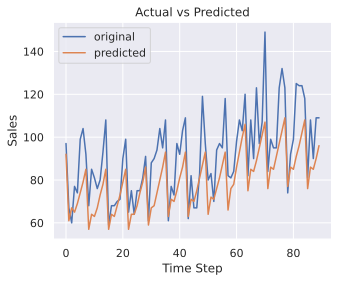

<Figure size 360x288 with 0 Axes>

In [60]:
# visualize result
plt.plot(real[random_storeitem_col].values[:90], label='original')
plt.plot(pred[random_storeitem_col].values[:90], label='predicted')

plt.xlabel('Time Step')
plt.ylabel('Sales')

plt.title("Actual vs Predicted")
plt.legend()
plt.show()

plt.savefig('LSTM Base Actual vs Predicted.png')

## Predict on test

In [61]:
# prepare test data
X_test, y_test = df_test[X_cols], df_test[y_cols]

In [62]:
y_test_pred, _ = model_eval(model, X_test, y_test)

1/1 [==============================] - 0s 17ms/step


In [63]:
test_template_df = pd.concat([X_test, y_test], axis=1)
test_template_df['is_test'] = np.repeat(True, test_template_df.shape[0])

test_pred = unscale(y_test_pred, scaler, test_template_df, toint=True)

In [64]:
test_pred.head()

,item_10_store_10_sales,item_10_store_1_sales,item_10_store_2_sales,item_10_store_3_sales,item_10_store_4_sales,item_10_store_5_sales,...,item_9_store_4_sales,item_9_store_5_sales,item_9_store_6_sales,item_9_store_7_sales,item_9_store_8_sales,item_9_store_9_sales
date,,,,,,,,,,,,,
2018-01-01,48,40,54,48,47,35,...,34,25,25,24,41,34
2018-01-02,51,43,57,52,50,38,...,36,27,26,25,44,36
2018-01-03,49,41,55,49,48,36,...,34,26,25,24,42,34
2018-01-04,51,43,57,52,50,38,...,36,27,26,25,44,36
2018-01-05,55,46,62,56,54,40,...,39,29,28,27,47,39


In [65]:
result = np.zeros(45000, dtype=np.int)
for i, s in storeitems():
    slice_start_idx = 90*10*(i-1) + 90*(s-1)
    slice_end_idx = slice_start_idx + 90
    col_name = f'item_{i}_store_{s}_sales'
    result[slice_start_idx:slice_end_idx] = test_pred[col_name].values
result = pd.DataFrame(result, columns=['sales'])
result.index.name = 'id'

result.head()

,sales
id,
0,15
1,16
2,15
3,16
4,17


In [66]:
result.to_csv('lstm-base_submission.csv')